In [68]:
import os
import time
import functools
import multiprocessing
from typing import Tuple, Callable

import pandas as pd
import numpy as np
import cv2
from numba import njit
from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map
import matplotlib.pyplot as plt

from metrics import (
    normalized_cross_correlation,
    sum_of_squared_differences,
    normalized_sum_of_squared_differences,
    sum_of_absolute_differences,
    structural_similarity_index,
    compile_metrics
)
from sm_dynamic_programming import (
    stereo_matching_dp_row,
    fill_occluded_pixels
)
from stereo_reconstruction import reconstruct_3d_scene

In [2]:
path_data = os.path.join(os.getcwd(), 'data_modified')

image_names = os.listdir(path_data)
image_sets = sorted(list(set([x.split('_')[0] for x in image_names])))

In [3]:
image_sets

['art', 'books', 'dolls', 'laundry', 'moebius', 'reindeer']

In [4]:
x = 13

bls = np.array([
    list(range(x)),
    list(range(x, 2*x)),
    list(range(2*x, 3*x))
])

temp = np.array([
    [4,5,6],
    [17,18,19],
    [30,31,32]
])
compile_metrics(temp, bls[:, 10:13])

In [9]:
path_dpms = os.path.join(os.getcwd(), 'disparity_maps_dp')

if not os.path.isdir(path_dpms):
    os.mkdir(path_dpms)

In [44]:
block_sizes = list(range(3, 11, 2))

metrics = [
    normalized_cross_correlation,
    sum_of_squared_differences,
    normalized_sum_of_squared_differences,
    structural_similarity_index
]
d_occlusion_costs = {
    'normalized_cross_correlation': np.arange(0.1, 1.1, 0.1),
    'sum_of_squared_differences': np.arange(100, 1100, 100),
    'normalized_sum_of_squared_differences': np.arange(0.1, 1.1, 0.1),
    'structural_similarity_index': np.arange(0.05, 0.55, 0.05)
}

In [28]:
d_occlusion_costs

{'normalized_cross_correlation': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'sum_of_squared_differences': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000]),
 'normalized_sum_of_squared_differences': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'sum_of_absolute_differences': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
 'structural_similarity_index': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])}

In [46]:
results = []
n_processes = 10

img_set = 'reindeer'

img_left = cv2.imread(os.path.join(path_data, f'{img_set}_left.png'), cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread(os.path.join(path_data, f'{img_set}_right.png'), cv2.IMREAD_GRAYSCALE)
img_disp = cv2.imread(os.path.join(path_data, f'{img_set}_disp.png'), cv2.IMREAD_GRAYSCALE)
img_disp = img_disp / 3
height, width = img_left.shape

params = []

for metr in metrics:
    for bs in block_sizes:
        for oc in d_occlusion_costs[metr.__name__]:
            params.append((metr, bs, round(np.float64(oc), 4)))

for par in tqdm(params):

    metr, bs, oc = par
    half_bs = bs // 2
    rows = list(range(half_bs, height - half_bs))

    func = functools.partial(
        stereo_matching_dp_row, 
        left_image=img_left, 
        right_image=img_right,
        cost_occlusion=oc,
        block_size=bs,
        metric=metr
    )
    start = time.time()

    with multiprocessing.Pool(processes=n_processes) as pool:
        res = pool.map(func, rows)
    
    elapsed = round(time.time() - start, 4)

    res = sorted(res, key=lambda x: x[0])
    dpm = np.zeros((height, width))
    dpm[half_bs: height - half_bs, :] = np.array([el[1] for el in res])

    dpm = fill_occluded_pixels(dpm)

    file_name = f'dp_disp_{metr.__name__}_{img_set}_{bs}_{oc}.png'
    plt.imsave(os.path.join(path_dpms, file_name), dpm, cmap='gray')
    score = metr(img_disp, dpm)
    results.append({
        'dataset': img_set,
        'metric': metr.__name__,
        'block_size': bs,
        'occluson_cost': oc,
        'dpm_file_name': file_name,
        'score': score,
        'execution_time': elapsed
    })

  0%|          | 0/160 [00:00<?, ?it/s]

In [51]:
df = pd.DataFrame(results)

In [52]:
df.head()

,dataset,metric,block_size,occluson_cost,dpm_file_name,score,execution_time
0,reindeer,normalized_cross_correlation,3,0.1,dp_disp_normalized_cross_correlation_reindeer_...,-0.207028,8.9404
1,reindeer,normalized_cross_correlation,3,0.2,dp_disp_normalized_cross_correlation_reindeer_...,-0.167112,9.2327
2,reindeer,normalized_cross_correlation,3,0.3,dp_disp_normalized_cross_correlation_reindeer_...,-0.144105,9.1422
3,reindeer,normalized_cross_correlation,3,0.4,dp_disp_normalized_cross_correlation_reindeer_...,-0.138202,8.9968
4,reindeer,normalized_cross_correlation,3,0.5,dp_disp_normalized_cross_correlation_reindeer_...,-0.133964,8.9080


In [53]:
df.to_csv('sm_dp_results.csv', index=False)

In [54]:
df.groupby(['dataset', 'metric'])[['score', 'execution_time']].mean()

score  execution_time
dataset  metric                                                             
reindeer normalized_cross_correlation          -1.859078e-01       12.736860
         normalized_sum_of_squared_differences  1.438681e+00       15.137390
         structural_similarity_index           -5.646911e-01        8.735637
         sum_of_squared_differences             1.254068e+09        5.750133

In [56]:
df.groupby(['dataset', 'metric', 'block_size'])[['score', 'execution_time']].mean()

score  \
dataset  metric                                block_size                 
reindeer normalized_cross_correlation          3          -1.470327e-01   
                                               5          -1.862664e-01   
                                               7          -1.997509e-01   
                                               9          -2.105813e-01   
         normalized_sum_of_squared_differences 3           9.105673e-01   
                                               5           1.589220e+00   
                                               7           1.616560e+00   
                                               9           1.638378e+00   
         structural_similarity_index           3          -4.842990e-01   
                                               5          -5.980085e-01   
                                               7          -5.973941e-01   
                                               9          -5.790629e-01   
         sum_of_squared_differences            3           1.325649e+07   
                                               5           7.743846e+08   
                                               7           1.803796e+09   
                                               9           2.424836e+09   

                                                           execution_time  
dataset  metric                                block_size                  
reindeer normalized_cross_correlation          3                  9.01723  
                                               5                 10.56272  
                                               7                 14.61049  
                                               9                 16.75700  
         normalized_sum_of_squared_differences 3                 11.66973  
                                               5                 13.68325  
                                               7                 16.38008  
                                               9                 18.81650  
         structural_similarity_index           3                  5.83504  
                                               5                  7.17272  
                                               7                  9.58876  
                                               9                 12.34603  
         sum_of_squared_differences            3                  4.84839  
                                               5                  5.30050  
                                               7                  6.04489  
                                               9                  6.80675

In [60]:
df.groupby(['dataset', 'metric', 'occluson_cost'])[['score', 'execution_time']].mean().sort_values('score')

score  \
dataset  metric                                occluson_cost                 
reindeer structural_similarity_index           0.05          -8.183404e-01   
                                               0.10          -8.133319e-01   
                                               0.15          -8.010378e-01   
                                               0.20          -7.733750e-01   
                                               0.25          -7.033887e-01   
                                               0.30          -6.078533e-01   
         normalized_cross_correlation          0.10          -4.576209e-01   
         structural_similarity_index           0.35          -4.333234e-01   
                                               0.40          -2.774613e-01   
         normalized_cross_correlation          0.20          -2.753504e-01   
         structural_similarity_index           0.45          -2.236889e-01   
                                               0.50          -1.951106e-01   
         normalized_cross_correlation          0.30          -1.888552e-01   
                                               0.40          -1.510685e-01   
                                               0.50          -1.393941e-01   
                                               0.60          -1.338092e-01   
                                               0.70          -1.304824e-01   
                                               0.80          -1.286139e-01   
                                               0.90          -1.275173e-01   
                                               1.00          -1.263663e-01   
         normalized_sum_of_squared_differences 0.70           1.007683e+00   
                                               0.80           1.016231e+00   
                                               0.90           1.044394e+00   
                                               0.60           1.064824e+00   
                                               1.00           1.083658e+00   
                                               0.50           1.222052e+00   
                                               0.40           1.545309e+00   
                                               0.30           1.971871e+00   
                                               0.20           2.200547e+00   
                                               0.10           2.230246e+00   
         sum_of_squared_differences            1000.00        6.932476e+08   
                                               900.00         7.493418e+08   
                                               800.00         8.346748e+08   
                                               700.00         9.409883e+08   
                                               600.00         1.077375e+09   
                                               500.00         1.175833e+09   
                                               400.00         1.320806e+09   
                                               300.00         1.592387e+09   
                                               200.00         1.918141e+09   
                                               100.00         2.237887e+09   

                                                              execution_time  
dataset  metric                                occluson_cost                  
reindeer structural_similarity_index           0.05                 8.736450  
                                               0.10                 8.736700  
                                               0.15                 8.671175  
                                               0.20                 8.707700  
                                               0.25                 8.754300  
                                               0.30                 8.710800  
         normalized_cross_correlation          0.10                12.732300  
         structural_similarity_index           0.35                 8.870900  
  

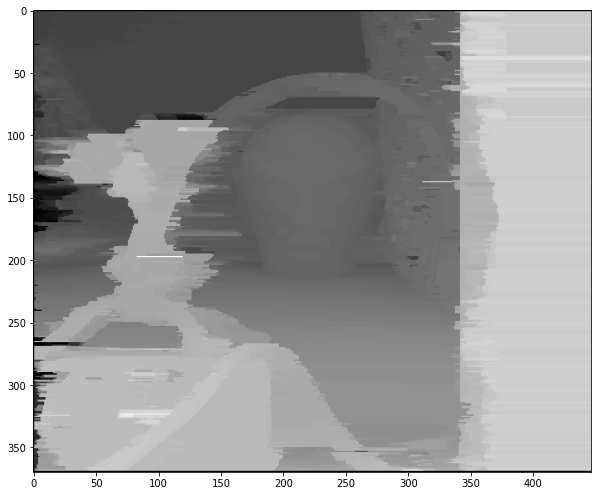

In [71]:
file_dp = 'dp_disp_sum_of_squared_differences_reindeer_3_200.0.png'

dpm = cv2.imread(os.path.join(path_dpms, file_dp), cv2.IMREAD_GRAYSCALE)

fig = plt.figure(figsize=(10, 10))
plt.imshow(dpm, cmap='gray')

## Stereo reconstruction of the 3D scene from the calculated disparity map

In [83]:
img_left = cv2.imread(os.path.join(path_data, f'{img_set}_left.png'))
img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)

param_baseline = 160 # mm
param_focal_length = 3740 # pixels
dmin = 230

points_dpm = reconstruct_3d_scene(
    img_left,
    dpm / 3, 
    param_baseline / 1000, 
    param_focal_length, 
    dmin
)

path_points = os.path.join(os.getcwd(), 'points_3d')
fn_points = f'{img_set}_3d_scene_dp.txt'

with open(os.path.join(path_points, fn_points), 'w') as file:
    for point in points_dpm:
        file.write(' '.join(str(p) for p in point))
        file.write('\n')

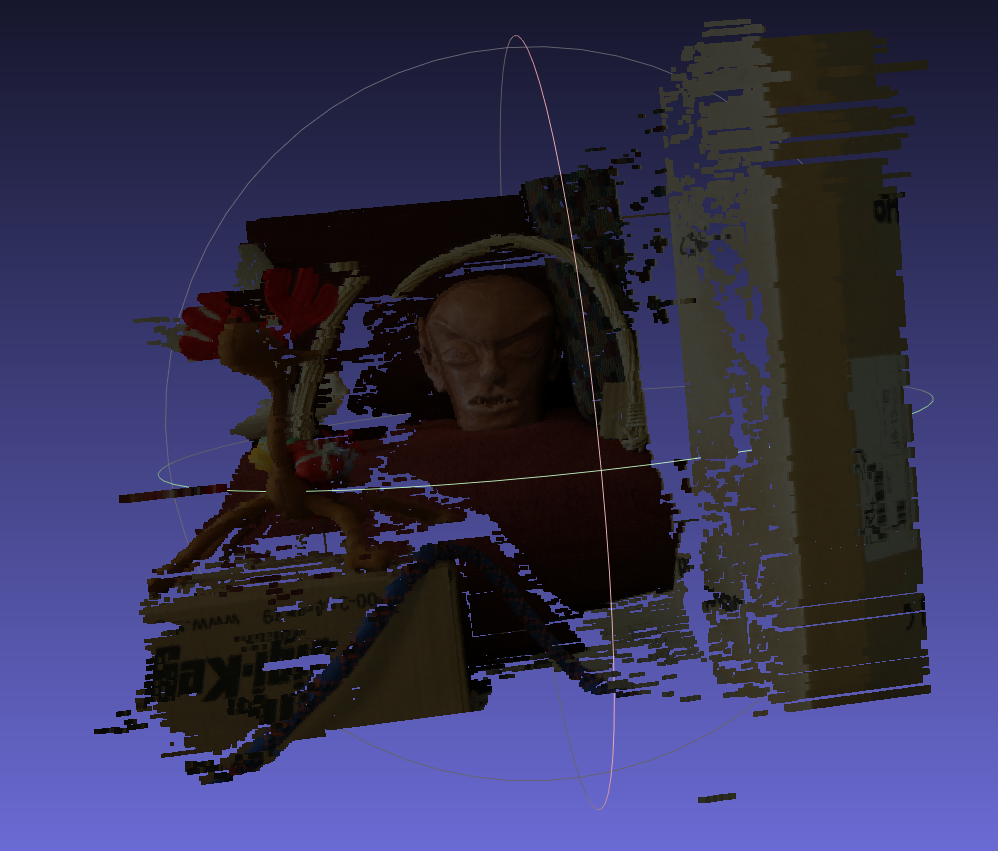

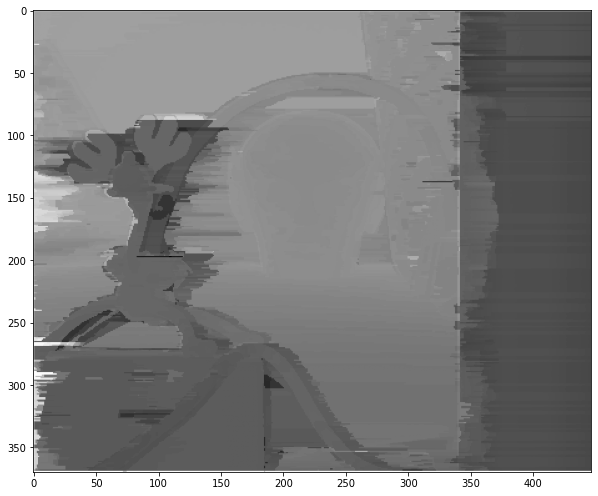

In [84]:
dpm_diff = img_disp - dpm

fig = plt.figure(figsize=(10, 10))
plt.imshow(dpm_diff, cmap='gray')